# Importing necessary packages

In [1]:
import numpy as np
import pandas as pd
from graphviz import Graph
import seaborn as sns
from sklearn import preprocessing
from est_MI import est_MI_JVHW
import matplotlib.pyplot as plt

# Preprocessing Data

In [2]:
raw_data= pd.read_csv('alarm10K.csv')

JVHW Estimator requires input columns of data to be integers. Hence label encode the multi-class data.

In [3]:
integerised_data=raw_data.copy()

le = preprocessing.LabelEncoder()
for i in range(0,37):
    le.fit(raw_data.iloc[:,i])
    integerised_data.iloc[:,i]=le.transform(raw_data.iloc[:,i])
    
    

In [4]:
column_names=raw_data.columns

# Plug-in Estimator

Plug-in estimator for mutual information.
$$\tilde{I}(X,Y)= \sum_{x,y} \tilde{p_{XY}}(x,y)log(\frac{\tilde{p_{XY}}(x,y)}{\tilde{p_X}(x)\tilde{p_Y}(y)})$$

where, $$ \tilde{p_{XY}}(x,y)=\frac{n_{xy}}{n_{total}}$$
       $$ \tilde{p_{X}}(x)=\frac{n_{x}}{n_{total}}$$
       $$ \tilde{p_{Y}}(y)=\frac{n_{y}}{n_{total}}$$

In [5]:
def micalculator(df):
    column_names=df.columns
    n=len(column_names)
    mi=np.zeros((37,37))
    for i in range(0,n):
        for j in range(i+1,n):
            #print i,j,column_names[i],column_names[j]
            joint=df.groupby([column_names[i],column_names[j]]).size().unstack(fill_value=0).stack()
            a=np.array(df.groupby([column_names[i]]).size())
            b=np.array(df.groupby([column_names[j]]).size())
            lena=len(a)
            lenb=len(b)
            a=a/float(len(df))
            b=b/float(len(df))
            prob_joint=np.array(joint).reshape((lena,lenb))
            prob_joint=prob_joint/float(len(df))
            #print prob_joint
            m_info_ab=0.0
            for k in range(0,lena):
                for m in range(0,lenb):
                    if(prob_joint[k][m]!=0.0):
                        m_info_ab+=prob_joint[k][m]*np.log2(prob_joint[k][m]/(a[k]*b[m]))
            #print m_info_ab
            mi[i][j]=m_info_ab
            mi[j][i]=m_info_ab
    return mi

# JVHW Estimator

In [6]:
def mi_jvhw_estimator(df):
    n=len(column_names)
    mi_jvhw=np.zeros((n,n))
    for i in range(0,n):
            for j in range(i+1,n):
                a=np.array(df.iloc[:,i])
                b=np.array(df.iloc[:,j])
                mi_jvhw[i][j]=est_MI_JVHW(a,b)
                mi_jvhw[j][i]=est_MI_JVHW(a,b)
    return mi_jvhw



# Prim's Algorithm Implementation

This implementation for finding $\textbf{minimum}$ spanning tree using Prim's Algorithm is obtained from https://coderbyte.com/algorithm/find-minimum-spanning-tree-using-prims-algorithm

I pass the negative of the mutual info matrix to this function to get the $\textbf{maximum}$ spanning tree. 

In [7]:
def prims(V, mi):
  vertex = 0
  MST = []
  edges = []
  visited = []
  minEdge = [None,None,float('inf')]
  
  # run prims algorithm until we create an MST
  # that contains every vertex from the graph
  while len(MST) != V-1:
    
    # mark this vertex as visited
    visited.append(vertex)
    
    # add each edge to list of potential edges
    for r in range(0, V):
      if mi[vertex][r] != 0:
        edges.append([vertex,r,mi[vertex][r]])
        
    # find edge with the smallest weight to a vertex
    # that has not yet been visited
    for e in range(0, len(edges)):
      if edges[e][2] < minEdge[2] and edges[e][1] not in visited:
        minEdge = edges[e]
        
    # remove min weight edge from list of edges
    edges.remove(minEdge)

    # push min edge to MST
    MST.append(minEdge)
      
    # start at new vertex and reset min edge
    vertex = minEdge[1]
    minEdge = [None,None,float('inf')]
    
  return MST
  




# MST using Plug-in Estimator  and JVHW Estimator

The tree is plotted and saved. The heat map of the mutual information matrix is printed.

('Tree Weight Sum:', 12.494817553078867)


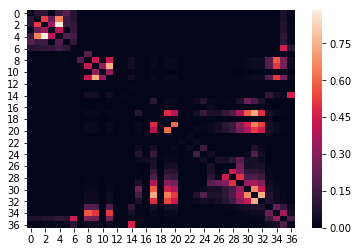

In [8]:
mi_10k=micalculator(raw_data)
mst= prims(37,-mi_10k)
dot=Graph( filename='mi_10k.gv')
tree_weight_mi_10k=0
for f in range(0,len(mst)):
    dot.edge(column_names[mst[f][0]],column_names[mst[f][1]])
    tree_weight_mi_10k=tree_weight_mi_10k-mst[f][2]
dot.view()
print("Tree Weight Sum:",tree_weight_mi_10k)
sns.heatmap(mi_10k)

('Tree Weight Sum:', 12.494817553078867)


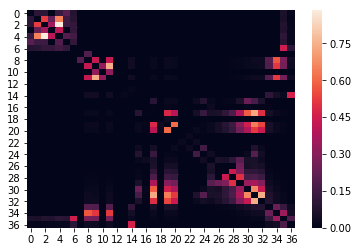

In [9]:
mi_jvhw_10k=mi_jvhw_estimator(integerised_data)
mst_jvhw= prims(37,-mi_jvhw_10k)
tree_weight_mi_jvhw_10k=0
dot=Graph( filename='mi_jvhw_10k.gv')
for f in range(0,len(mst_jvhw)):
    dot.edge(column_names[mst_jvhw[f][0]],column_names[mst_jvhw[f][1]])
    tree_weight_mi_jvhw_10k=tree_weight_mi_jvhw_10k-mst[f][2]
dot.view()
print("Tree Weight Sum:",tree_weight_mi_jvhw_10k)
sns.heatmap(mi_jvhw_10k)

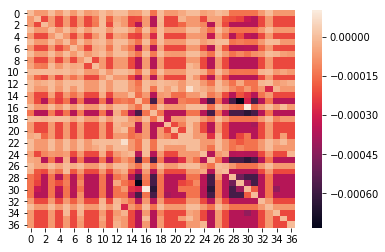

In [10]:
mi_diff_10k=mi_jvhw_10k-mi_10k
sns.heatmap(mi_diff_10k)

For 10000 points, both the estimators give the same spanning tree and the mutual info matrix is not as different either, as inferred from the heatmap of mi_diff. The difference is of the order of 0.001

# Convergence Analysis

The given dataset is randomly sampled to generate a dataset of reduced number of rows as specified in num_rows. Then, the maximum spanning tree is obtained based on both the estimators and sum of the graph-weights is compared to get a sense of the convergence.

In [11]:
num_rows=[100,200,400,800,1600,2000,2400,2800,3200,6400,8100,10000]
tree_weight=np.zeros((len(num_rows),1))
tree_weight_jvhw=np.zeros((len(num_rows),1))
for i in range(0,len(num_rows)):
    mi=micalculator(raw_data.sample(n=num_rows[i],random_state=0))
    mst= prims(37,-mi)
    for f in range(0,len(mst)):
        tree_weight[i]=tree_weight[i]-mst[f][2]
    #print("Tree Weight Sum:",tree_weight[i])

    mi_jvhw=mi_jvhw_estimator(integerised_data.sample(n=num_rows[i],random_state=0))
    mst_jvhw= prims(37,-mi_jvhw)
    for f in range(0,len(mst_jvhw)):
        tree_weight_jvhw[i]=tree_weight_jvhw[i]-mst_jvhw[f][2]
    #print("Tree Weight Sum:",tree_weight_jvhw[i])

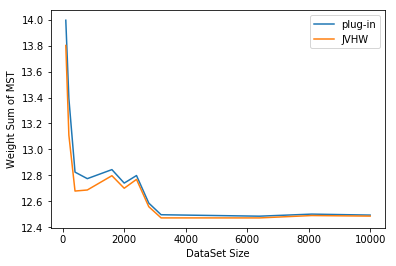

In [12]:
plt.plot(num_rows,tree_weight,label='plug-in')
plt.plot(num_rows,tree_weight_jvhw,label='JVHW')
plt.legend()
plt.xlabel('DataSet Size')
plt.ylabel('Weight Sum of MST')
plt.show()

JVHW Estimator is found to be better than plug-in Estimator at all data set sizes